In [5]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
%matplotlib inline
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf,pacf
from statsmodels.tsa.seasonal import seasonal_decompose
import warnings
warnings.filterwarnings('ignore')

In [6]:
df=pd.read_csv("Company Stock and Investment.csv")

In [7]:
df.head()

,Date,Oil Investments,Gold Investments,Comp Stock,Other sharesInvestments
0,31-12-2009,0.025417,0.000150,0.017354,0.006848
1,04-01-2010,0.026830,0.001097,0.015565,-0.004609
2,05-01-2010,0.002699,0.001560,0.001729,0.005900
3,06-01-2010,0.021688,0.006009,-0.015906,-0.018116
4,07-01-2010,-0.006256,0.000221,-0.001849,-0.017013


In [8]:
df=df.drop(['Gold Investments','Oil Investments','Other sharesInvestments'],axis=1)
df

,Date,Comp Stock
0,31-12-2009,0.017354
1,04-01-2010,0.015565
2,05-01-2010,0.001729
3,06-01-2010,-0.015906
4,07-01-2010,-0.001849
...,...,...
1979,09-11-2017,-0.002043
1980,10-11-2017,-0.006880
1981,13-11-2017,-0.004008
1982,14-11-2017,-0.015118


In [9]:
df['Date']=pd.to_datetime(df['Date'],format='%d-%m-%Y')
df

,Date,Comp Stock
0,2009-12-31,0.017354
1,2010-01-04,0.015565
2,2010-01-05,0.001729
3,2010-01-06,-0.015906
4,2010-01-07,-0.001849
...,...,...
1979,2017-11-09,-0.002043
1980,2017-11-10,-0.006880
1981,2017-11-13,-0.004008
1982,2017-11-14,-0.015118


In [10]:
df.set_index('Date', inplace=True)

In [11]:
df.describe()

,Comp Stock
count,1984.000000
mean,0.001007
std,0.016017
min,-0.123558
25%,-0.006926
50%,0.000876
75%,0.009708
max,0.088741


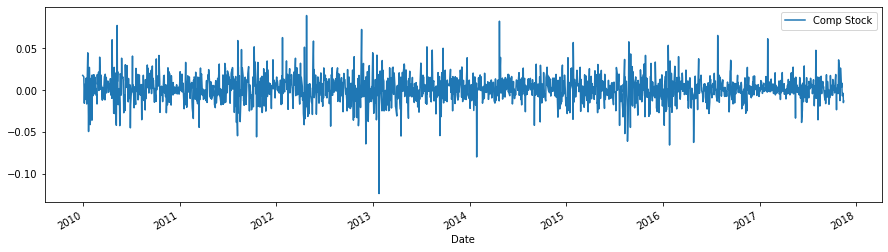

In [12]:
df.plot(figsize=(15,4))

In [13]:
def adf_test(price):
    result=adfuller(price) # same as above ,variable name changed
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data  is stationary")
    else:
        print("weak evidence against null hypothesis, time series is non-stationary ")

In [14]:
adf_test(df['Comp Stock'])

ADF Test Statistic : -12.47338626590827
p-value : 3.2077742930894446e-23
#Lags Used : 12
Number of Observations Used : 1971
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data  is stationary


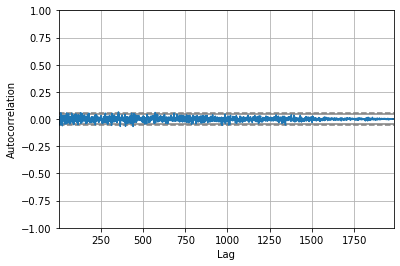

In [15]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(df['Comp Stock']) 
plt.show()

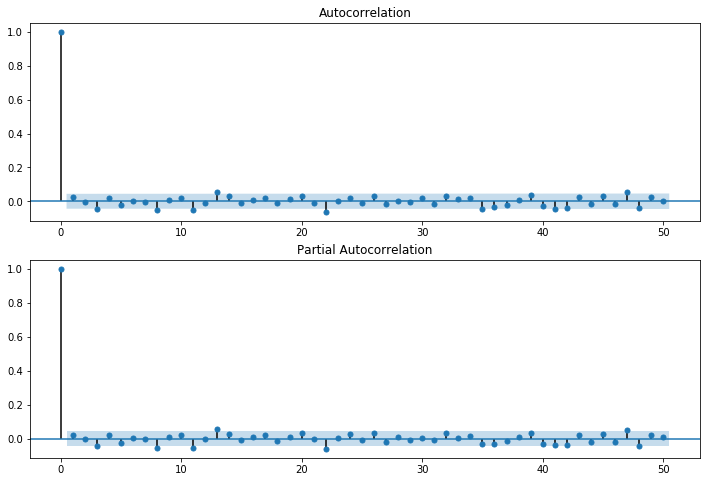

In [16]:
import statsmodels.api as sm
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df['Comp Stock'],lags=50,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df['Comp Stock'],lags=50,ax=ax2)

So from the above Auto correlation plot we can see that there is no strong evidance

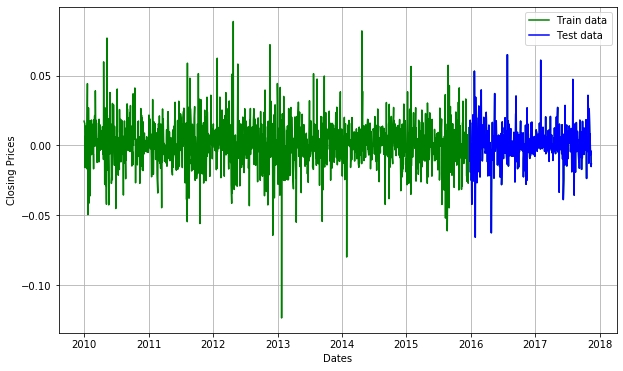

In [17]:
size=int(len(df)*0.76)
train_data, test_data = df[0:size], df[size:]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()

In [18]:
from statsmodels.tsa.arima_model import ARIMA
model1=ARIMA(train_data,order=(1,1,1)) # this order is p d q(0 or 1) 
results=model1.fit()

In [19]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:           D.Comp Stock   No. Observations:                 1506
Model:                 ARIMA(1, 1, 1)   Log Likelihood                4008.261
Method:                       css-mle   S.D. of innovations              0.017
Date:                Thu, 22 Oct 2020   AIC                          -8008.523
Time:                        23:48:33   BIC                          -7987.254
Sample:                             1   HQIC                         -8000.601
                                                                              
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const              -1.948e-06   8.36e-06     -0.233      0.816   -1.83e-05    1.44e-05
ar.L1.D.Comp Stock     0.0218      0.027      0.819      0.413      -0.030       0.074
ma.L1.D.Comp Stock    -0.9819      0.015    -65.751      0.000      -1.011      -0.953
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           45.8523           +0.0000j           45.8523            0.0000
MA.1            1.0184           +0.0000j            1.0184            0.0000
-----------------------------------------------------------------------------
"""

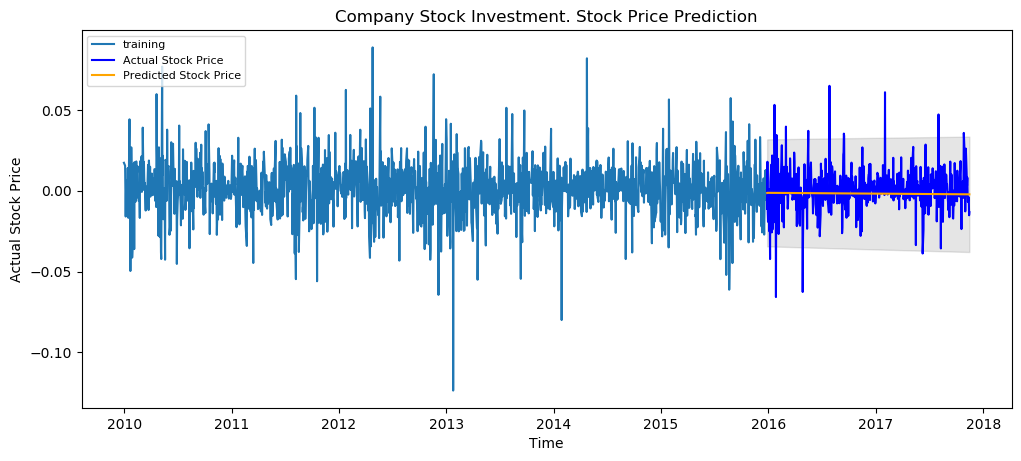

In [20]:
#Now let's start forecast the stock prices on the test dataset keeping 95% confidence level.
fc, se, conf = results.forecast(477, alpha=0.05)  # 95% confidence
fc_series = pd.Series(fc, index=test_data.index)
lower_series = pd.Series(conf[:, 0], index=test_data.index)
upper_series = pd.Series(conf[:, 1], index=test_data.index)
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, color = 'blue', label='Actual Stock Price')
plt.plot(fc_series, color = 'orange',label='Predicted Stock Price')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.10)
plt.title('Company Stock Investment. Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Actual Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [21]:
from sklearn.metrics import mean_squared_error,mean_absolute_error
mse = mean_squared_error(test_data, fc)
print('MSE: '+str(mse))
mae = mean_absolute_error(test_data, fc)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(test_data, fc))
print('RMSE: '+str(rmse))

MSE: 0.00018297583480890578
MAE: 0.00938166293691732
RMSE: 0.013526856057817196


In [22]:
fc_series

Date
2015-12-28   -0.001324
2015-12-29   -0.001238
2015-12-30   -0.001238
2015-12-31   -0.001240
2016-01-04   -0.001242
                ...   
2017-11-09   -0.002153
2017-11-10   -0.002155
2017-11-13   -0.002157
2017-11-14   -0.002159
2017-11-15   -0.002161
Length: 477, dtype: float64

In [23]:
from pandas.tseries.offsets import DateOffset
future_dates=[df.index[-1]+ DateOffset(days=x)for x in range(0,1508)]

In [24]:
future_datest_df=pd.DataFrame(index=future_dates[1:],columns=df.columns)

In [25]:
future_datest_df.tail()

,Comp Stock
2021-12-27,NaN
2021-12-28,NaN
2021-12-29,NaN
2021-12-30,NaN
2021-12-31,NaN


In [26]:
fc1, se1, conf1 = results.forecast(1507, alpha=0.05)  # 95% confidence
fc1_series = pd.Series(fc1, index=future_datest_df.index)

In [27]:
fc1_series

2017-11-16   -0.001324
2017-11-17   -0.001238
2017-11-18   -0.001238
2017-11-19   -0.001240
2017-11-20   -0.001242
                ...   
2021-12-27   -0.004159
2021-12-28   -0.004161
2021-12-29   -0.004163
2021-12-30   -0.004165
2021-12-31   -0.004167
Length: 1507, dtype: float64

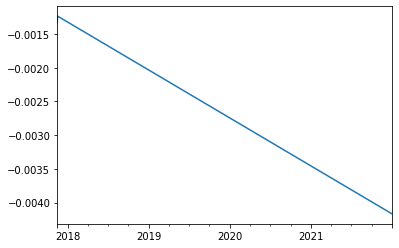

In [28]:
fc1_series.plot()

In [29]:
fc1_series.to_excel("Comp_Stock_Investment_Prediction.xlsx")

From the above we can see that for future dates the vlaues of the stocks are progressively low, so company stock investment is not the best option 